In [1]:
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.neighbors import (KNeighborsClassifier,
                               KNeighborsRegressor)
from sklearn.model_selection import (cross_val_score,
                                     cross_val_predict,
                                     GridSearchCV)
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from yellowbrick.model_selection import ValidationCurve, LearningCurve

sns.set_style('whitegrid')
DATA_PATH = Path(f'data/kc_house_data.csv')

In [2]:
house_sales = pd.read_csv(DATA_PATH)
house_sales = house_sales.drop(['id', 'zipcode', 'lat', 'long', 'date'], axis=1)
house_sales.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,6210.000000,871200.000000


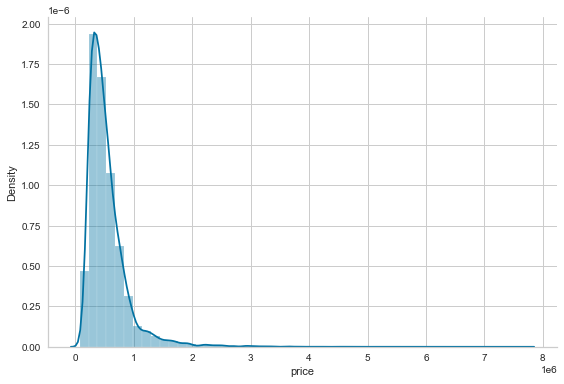

In [3]:
sns.distplot(house_sales.price)
sns.despine()
plt.tight_layout();

<Axes: xlabel='price', ylabel='Density'>

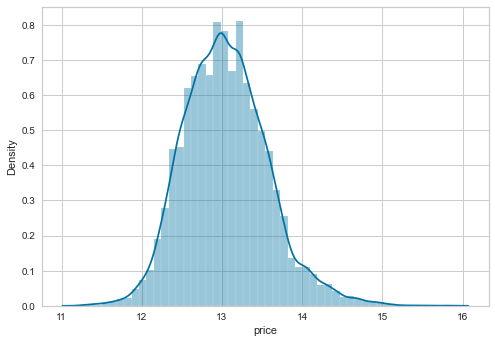

In [4]:
# less skewed distribution by log transformation
# comparing arithmatic mean after log transforming is geometric mean of the original data
# after log transformation, it can be used to estimation by the linear MDL
y = np.log(house_sales.price)
X_all = house_sales.drop('price', axis=1)
# house_sales.describe()

sns.distplot(y)

In [5]:
mi_reg = pd.Series(mutual_info_regression(X_all, y), index=X_all.columns).sort_values(ascending=False)
mi_reg[:12]

sqft_living      0.350720
grade            0.349850
sqft_living15    0.271463
sqft_above       0.259820
bathrooms        0.203644
sqft_lot15       0.084903
bedrooms         0.078259
yr_built         0.077150
floors           0.074248
sqft_basement    0.070208
sqft_lot         0.063553
view             0.054505
dtype: float64

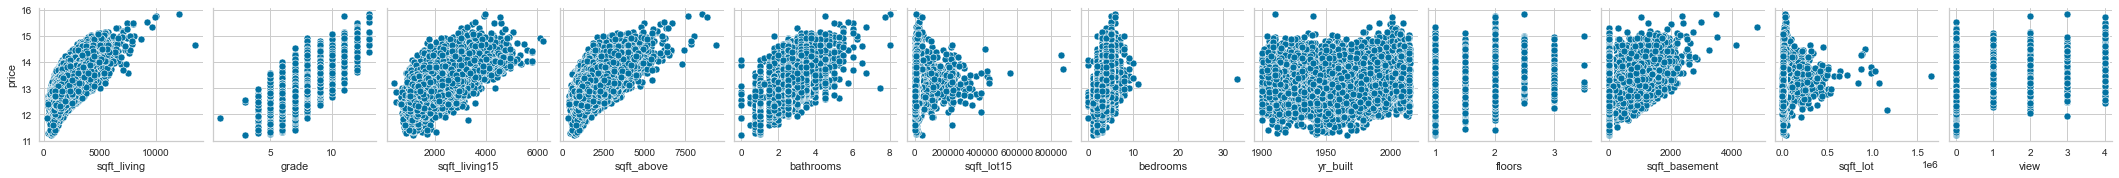

In [6]:
X = X_all.loc[:, mi_reg[:12].index]
mi_reg[:12].index
g = sns.pairplot(X.assign(price=y), y_vars=['price'], x_vars=X.columns)
sns.despine();

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sqft_living    21613 non-null  int64  
 1   grade          21613 non-null  int64  
 2   sqft_living15  21613 non-null  int64  
 3   sqft_above     21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_lot15     21613 non-null  int64  
 6   bedrooms       21613 non-null  int64  
 7   yr_built       21613 non-null  int64  
 8   floors         21613 non-null  float64
 9   sqft_basement  21613 non-null  int64  
 10  sqft_lot       21613 non-null  int64  
 11  view           21613 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 2.0 MB


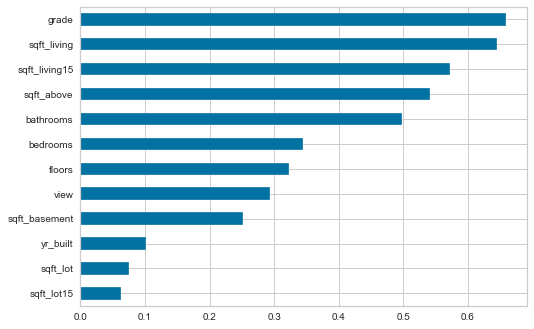

In [8]:
# scipy.stats spearmanr: rank-order correlation coefficient, nonparametric measure of the of monotonicity of the relationship btw 2 datasets
corr = X.apply(lambda x: spearmanr(x, y)[0])
corr.sort_values().plot.barh();

In [9]:
X_scaled = scale(X)  # Standard Normal Gaussian basic scale, features should be numbers
model = KNeighborsRegressor()
model.fit(X=X_scaled, y=y)
y_pred = model.predict(X_scaled)

({'rmse': 0.2531189062758111,
  'rmsle': 0.01808580147206913,
  'mean_ae': 0.19554792748853037,
  'median_ae': 0.15633199732912573,
  'r2score': 0.7693083416151189},
 0.008891788741744278)

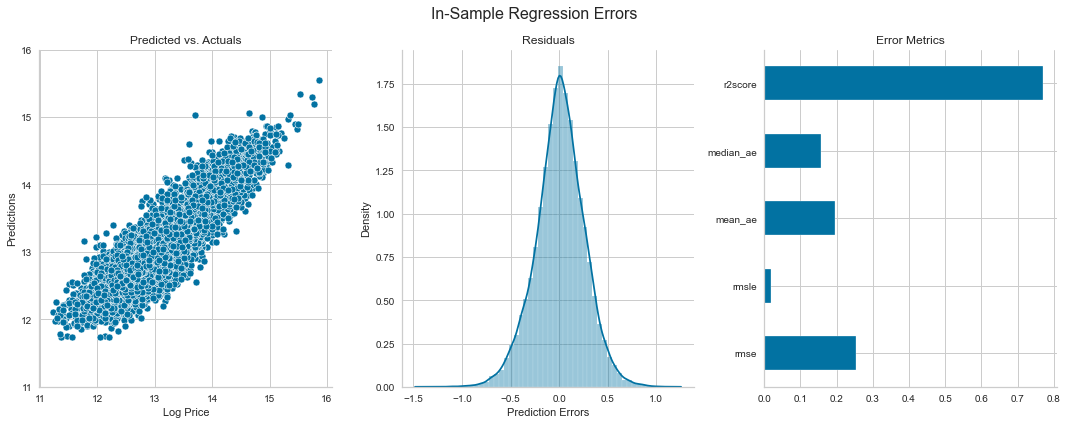

In [10]:
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_squared_log_error,
                             median_absolute_error,
                             explained_variance_score,
                             r2_score)

# error: the deviation from the true value
# residual: the deviation from an estimated value
error = (y - y_pred).rename('Prediction Errors')

scores = dict(rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
              rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
              mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
              median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
              r2score=explained_variance_score(y_true=y, y_pred=y_pred)
              )

fig, axes = plt.subplots(ncols=3, figsize=(15, 6))
# 1st plot
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
axes[0].set_title('Predicted vs. Actuals')

# 2nd plot
sns.distplot(error, ax=axes[1])
axes[1].set_title('Residuals')

# 3rd plot
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')
fig.suptitle('In-Sample Regression Errors', fontsize=16)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.88)

scores, error.mean()

(   n  fold      RMSE
 0  1     0  0.396360
 1  1     1  0.404368
 2  1     2  0.400001
 3  1     3  0.401907
 4  1     4  0.377415,
 [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

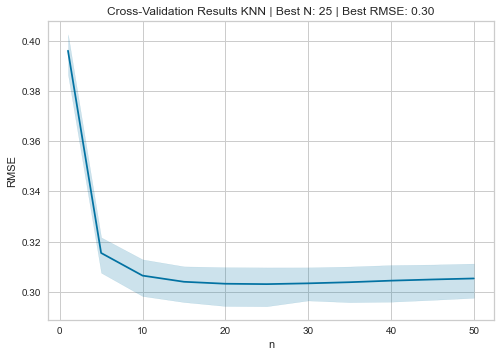

In [11]:
def rmse(y_true, pred):
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=pred))

rmse_score = make_scorer(rmse) # validation standard

cv_rmse = {}
n_neighbors = [1] + list(range(5, 51, 5))
for n in n_neighbors:
    pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_neighbors=n))])
    cv_rmse[n] = cross_val_score(pipe, X=X, y=y, scoring=rmse_score, cv=5)

cv_rmse = pd.DataFrame.from_dict(cv_rmse, orient='index')
best_n, best_rmse = cv_rmse.mean(1).idxmin(), cv_rmse.mean(1).min()
cv_rmse = cv_rmse.stack().reset_index()
cv_rmse.columns = ['n', 'fold', 'RMSE']

ax = sns.lineplot(x='n', y='RMSE', data=cv_rmse)
ax.set_title(f'Cross-Validation Results KNN | Best N: {best_n:d} | Best RMSE: {best_rmse:.2f}');
cv_rmse.head(), n_neighbors

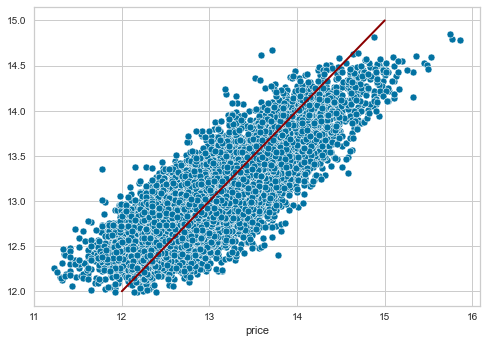

In [19]:
# Actual vs Predicted
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_neighbors=best_n))])
y_pred = cross_val_predict(pipe, X, y, cv=5)

ax = sns.scatterplot(x=y, y=y_pred)
y_range = list(range(int(y.min() + 1), int(y.max() + 1))) # actual value range
pd.Series(y_range, index=y_range).plot(ax=ax, lw=2, c='darkred');

{'rmse': 0.3032318823154326,
 'rmsle': 0.021636673484387296,
 'mean_ae': 0.23888268501814847,
 'median_ae': 0.19898283909279968,
 'r2score': 0.6698284232457976}

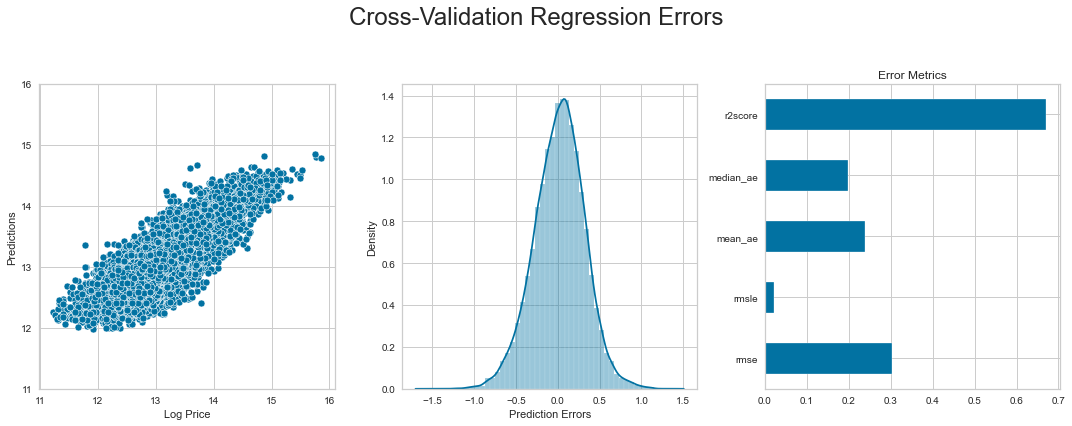

In [116]:
error = (y - y_pred).rename('Prediction Errors')

scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred)
)

fig, axes = plt.subplots(ncols=3, figsize=(15, 6))
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
sns.distplot(error, ax=axes[1])
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')
fig.suptitle('Cross-Validation Regression Errors', fontsize=24)
fig.tight_layout()
plt.subplots_adjust(top=.8);
scores

In [124]:
# GridSearchCV
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor())])

n_folds = 5
n_neighbors = tuple(range(5, 101, 5))

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=rmse_score,
                         n_jobs=-1
                         )
estimator.fit(X=X, y=y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': (5, 10, 15, 20, 25, 30, 35, 40, 45,
                                              50, 55, 60, 65, 70, 75, 80, 85,
                                              90, 95, 100)},
             scoring=make_scorer(rmse))

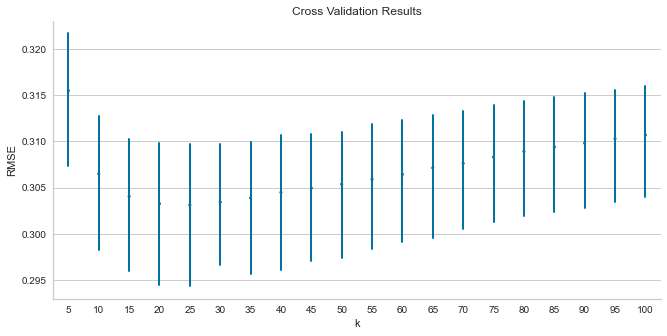

In [126]:
cv_results = estimator.cv_results_

test_scores = pd.DataFrame({fold: cv_results[f'split{fold}_test_score'] for fold in range(n_folds)},
                           index=n_neighbors).stack().reset_index()
test_scores.columns = ['k', 'fold', 'RMSE']

mean_rmse = test_scores.groupby('k').RMSE.mean()
best_k, best_score = mean_rmse.idxmin(), mean_rmse.min()
sns.pointplot(x='k', y='RMSE', data=test_scores, scale=.3, join=False, errwidth=2)
plt.title('Cross Validation Results')
sns.despine()
plt.tight_layout()
plt.gcf().set_size_inches(10, 5);

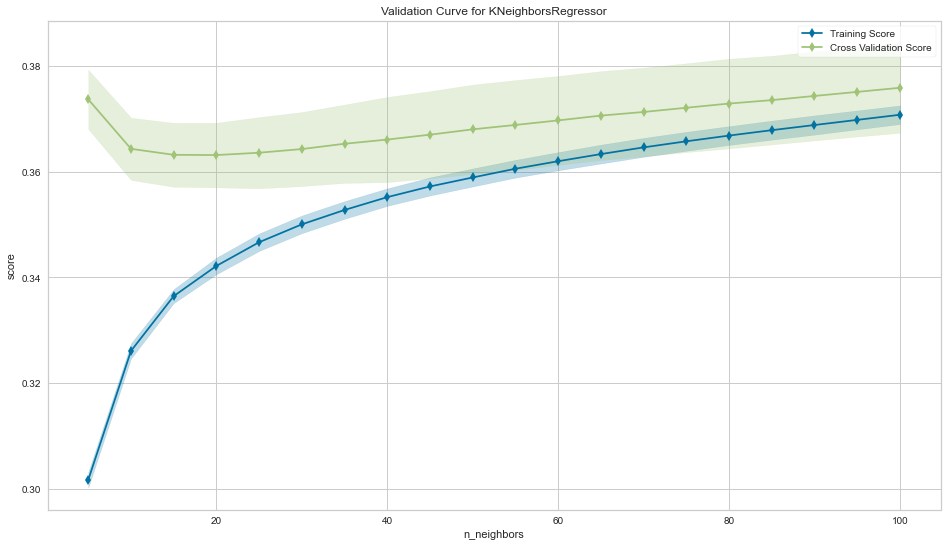

<Figure size 432x288 with 0 Axes>

In [127]:
fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(KNeighborsRegressor(),
                            param_name='n_neighbors',
                            param_range=n_neighbors,
                            cv=5,
                            scoring=rmse_score,
                            n_jobs=-1,
                            ax=ax)
val_curve.fit(X, y)
val_curve.poof()
sns.despine()
fig.tight_layout();

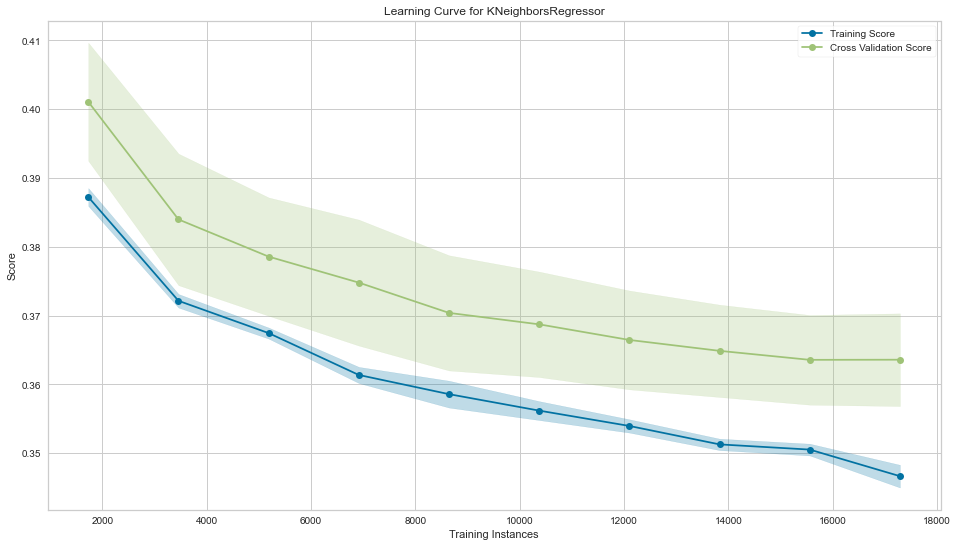

<Figure size 432x288 with 0 Axes>

In [72]:
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(KNeighborsRegressor(n_neighbors=best_k),
                        train_sizes=np.arange(.1, 1.01, .1),
                        scoring=rmse_score,
                        cv=5,
                        #                         n_jobs=-1,
                        ax=ax)
l_curve.fit(X, y)
l_curve.poof()
sns.despine()
fig.tight_layout();

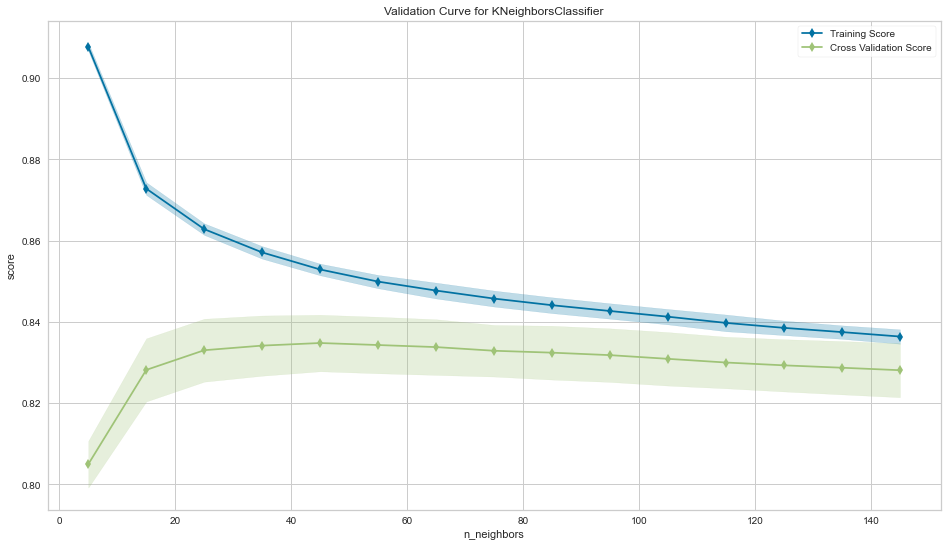

<Figure size 432x288 with 0 Axes>

In [128]:
# Binary Classification
y_binary = (y > y.median()).astype(int)

n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = 'roc_auc'

pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=scoring,
                         n_jobs=-1
                         )
estimator.fit(X=X, y=y_binary)
best_k = estimator.best_params_['knn__n_neighbors']

fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(KNeighborsClassifier(),
                            param_name='n_neighbors',
                            param_range=n_neighbors,
                            cv=n_folds,
                            scoring=scoring,
                            #                       n_jobs=-1,
                            ax=ax)
val_curve.fit(X, y_binary)
val_curve.poof()
sns.despine()
fig.tight_layout();

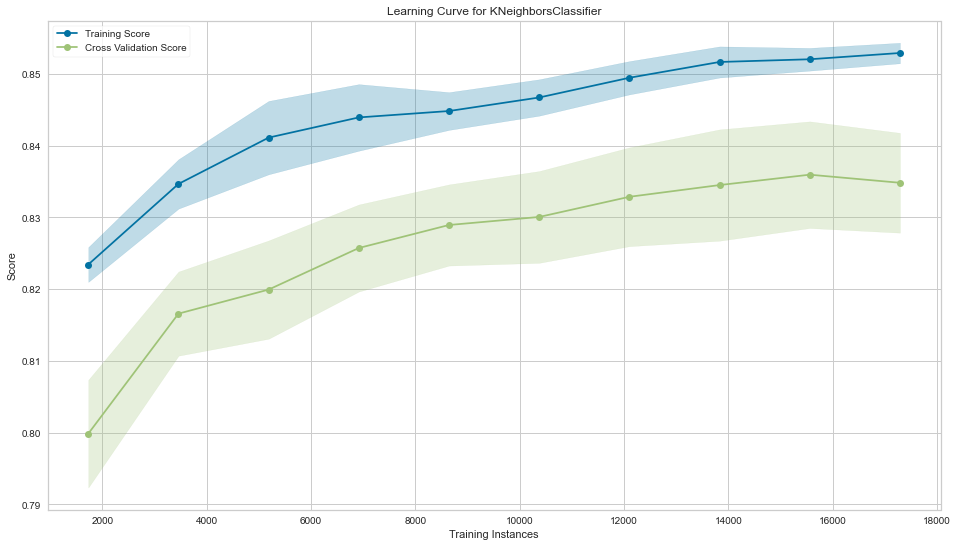

<Figure size 432x288 with 0 Axes>

In [74]:
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(KNeighborsClassifier(n_neighbors=best_k),
                        train_sizes=np.arange(.1, 1.01, .1),
                        scoring=scoring,
                        cv=5,
                        #                         n_jobs=-1,
                        ax=ax)
l_curve.fit(X, y_binary)
l_curve.poof()
sns.despine()
fig.tight_layout();

In [75]:

from sklearn.metrics import (classification_report,
                             accuracy_score,
                             zero_one_loss,
                             roc_auc_score,
                             roc_curve,
                             brier_score_loss,
                             cohen_kappa_score,
                             confusion_matrix,
                             fbeta_score,
                             hamming_loss,
                             hinge_loss,
                             jaccard_score,
                             log_loss,
                             matthews_corrcoef,
                             f1_score,
                             average_precision_score,
                             precision_recall_curve)

y_score = cross_val_predict(KNeighborsClassifier(best_k), X=X, y=y_binary, cv=5,
                            n_jobs=-1, method='predict_proba')[:, 1]

pred_scores = dict(y_true=y_binary, y_score=y_score)

roc_auc_score(**pred_scores)

cols = ['False Positive Rate', 'True Positive Rate', 'threshold']
roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

precision, recall, ts = precision_recall_curve(y_true=y_binary, probas_pred=y_score)
pr_curve = pd.DataFrame({'Precision': precision, 'Recall': recall})

f1 = pd.Series({t: f1_score(y_true=y_binary, y_pred=y_score > t) for t in ts})
best_threshold = f1.idxmax()

roc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   False Positive Rate  47 non-null     float64
 1   True Positive Rate   47 non-null     float64
 2   threshold            47 non-null     float64
dtypes: float64(3)
memory usage: 1.2 KB


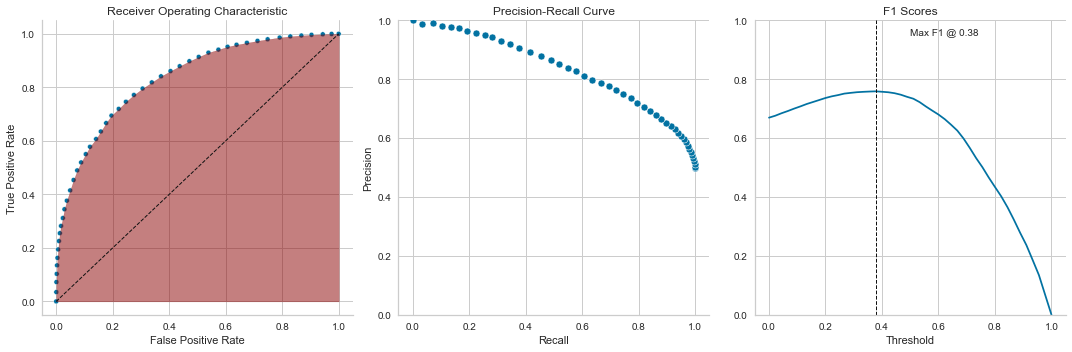

In [129]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

ax = sns.scatterplot(x='False Positive Rate', y='True Positive Rate', data=roc, size=5, legend=False, ax=axes[0])
axes[0].plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color='k', ls='--', lw=1)
axes[0].fill_between(y1=roc['True Positive Rate'], x=roc['False Positive Rate'], alpha=.5, color='darkred')
axes[0].set_title('Receiver Operating Characteristic')

sns.scatterplot(x='Recall', y='Precision', data=pr_curve, ax=axes[1])
axes[1].set_ylim(0, 1)
axes[1].set_title('Precision-Recall Curve')

f1.plot(ax=axes[2], title='F1 Scores', ylim=(0, 1))
axes[2].set_xlabel('Threshold')
axes[2].axvline(best_threshold, lw=1, ls='--', color='k')
axes[2].text(s=f'Max F1 @ {best_threshold:.2f}', x=.5, y=.95)
sns.despine()
fig.tight_layout();

In [77]:
average_precision_score(y_true=y_binary, y_score=y_score)

0.8324202685406307

In [78]:
brier_score_loss(y_true=y_binary, y_prob=y_score)

0.16669489613304292

In [79]:
y_pred = y_score > best_threshold
scores = dict(y_true=y_binary, y_pred=y_pred)
scores

{'y_true': 0        0
 1        1
 2        0
 3        1
 4        1
         ..
 21608    0
 21609    0
 21610    0
 21611    0
 21612    0
 Name: price, Length: 21613, dtype: int32,
 'y_pred': array([False,  True, False, ..., False,  True, False])}

In [80]:
fbeta_score(**scores, beta=1)

0.7591823028166058

In [81]:
classification_report(**scores)

'              precision    recall  f1-score   support\n\n           0       0.80      0.63      0.70     10864\n           1       0.69      0.84      0.76     10749\n\n    accuracy                           0.73     21613\n   macro avg       0.75      0.74      0.73     21613\nweighted avg       0.75      0.73      0.73     21613\n'

In [82]:
confusion_matrix(**scores)

array([[6833, 4031],
       [1706, 9043]], dtype=int64)

In [83]:
accuracy_score(**scores)

0.7345579049646046

In [84]:
zero_one_loss(**scores)

0.2654420950353954

In [85]:
hamming_loss(**scores)

0.26544209503539534

In [86]:
cohen_kappa_score(y1=y_binary, y2=y_pred)

0.46970786242045426

In [87]:
hinge_loss(y_true=y_binary, pred_decision=y_pred)

0.7681025308841901

In [88]:
jaccard_score(**scores)

0.6118403247631935

In [89]:
log_loss(**scores)

9.168194297637704

In [90]:
matthews_corrcoef(**scores)

0.48094552980464034

In [91]:
y_multi = pd.qcut(y, q=3, labels=[0, 1, 2])
n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = 'accuracy'
pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         n_jobs=-1
                         )
estimator.fit(X=X, y=y_multi)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85,
                                              95, 105, 115, 125, 135, 145)})

In [92]:
y_pred = cross_val_predict(estimator.best_estimator_,
                           X=X,
                           y=y_multi,
                           cv=5,
                           n_jobs=-1,
                           method='predict')
print(classification_report(y_true=y_multi, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.67      0.70      0.69      7226
           1       0.52      0.51      0.51      7223
           2       0.76      0.74      0.75      7164

    accuracy                           0.65     21613
   macro avg       0.65      0.65      0.65     21613
weighted avg       0.65      0.65      0.65     21613

